# See how to change the underlying coordinates_AIS file to fix issues on land

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import cartopy.crs as ccrs

Load files

In [3]:
folder   ='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'
domcfg   = xr.open_dataset(f'{folder}domain_cfg-20240123-filledlakes.nc')
meshmask = xr.open_dataset(f'{folder}mesh_mask-20240123-filledlakes.nc')

domcfg_orig   = xr.open_dataset(f'{folder}domain_cfg-20231025.nc')
meshmask_orig = xr.open_dataset(f'{folder}mesh_mask-20231025.nc')

Create a new bathymetry file starting from the originals:

In [17]:
def fill_lakes(array, dim='2D'):

    if dim=='2D':
        array[0, 186, slice(128,135)] = 0
        array[0, slice(447,453), slice(848,850)] = 0
        array[0, slice(441,446), slice(848,853)] = 0
        array[0, slice(426,438), slice(856,870)] = 0
        array[0, slice(424,431), slice(863,872)] = 0
        array[0, 318, slice(1350,1352)] = 0
        #array[0, slice(447,453), slice(848,850)] = 0
    elif dim=='3D':
        array[0, :, 186, slice(128,135)] = 0
        array[0, :, slice(447,453), slice(848,850)]   = 0
        array[0, :, slice(441,446), slice(848,853)]   = 0
        array[0, :, slice(426,438), slice(856,870)]   = 0
        array[0, :, slice(424,431), slice(863,872)]   = 0
        array[0, :, 318           , slice(1350,1352)] = 0
    else:
        raise Exception('Only set up for dimension 2D or 3D')

    return array

In [18]:
def fill_problem_iceshelf(array, dim='2D'):
    # make problem iceshelf land...
    if dim=='2D':
        array[0, 309, 1327] = 0
    elif dim=='3D':
        # array[0, :, slice(308,311), slice(1325,1328)] = 0
        array[0, :, 309, 1327] = 0
    else:
        raise Exception('Only set up for dimension 2D or 3D')

    return array

In [19]:
# ---- Domain config file ------------
domcfg_new   = domcfg_orig.copy()
for var in ['bottom_level', 'bathy_metry', 'isf_draft', 'top_level']:
    new_array       = fill_lakes(domcfg_new[var].values, dim='2D')
    new_array       = fill_problem_iceshelf(new_array, dim='2D')
    domcfg_new[var] = (('time_counter', 'y', 'x'), new_array)

domcfg_new.to_netcdf(f'{folder}domain_cfg-20240305.nc')

# ---- Mesh mask file ------------
meshmask_new = meshmask_orig.copy()
for var in ['bathy_metry', 'mbathy', 'misf', 'mhw', 'hw', 'tmaskutil', 'umaskutil', 'vmaskutil']:
    new_array         = fill_lakes(meshmask_new[var].values, dim='2D')
    new_array         = fill_problem_iceshelf(new_array, dim='2D')
    meshmask_new[var] = (('time_counter', 'y', 'x'), new_array)

for var in ['tmask', 'umask', 'vmask', 'fmask']:
    new_array         = fill_lakes(meshmask_new[var].values, dim='3D')
    new_array         = fill_problem_iceshelf(new_array, dim='3D')
    meshmask_new[var] = (('time_counter', 'nav_lev', 'y', 'x'), new_array)

meshmask_new.to_netcdf(f'{folder}mesh_mask-20240305.nc')

View error region: (1327, 310)

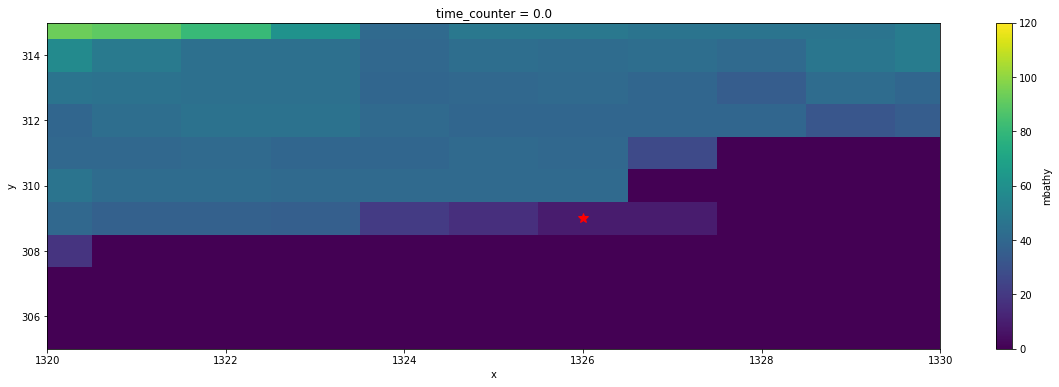

In [11]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
meshmask_orig.mbathy.isel(time_counter=0).plot(ax=ax, xlim=(1320, 1330), ylim=(305, 315))
ax.plot([1326],[309], '*r', markersize=10);

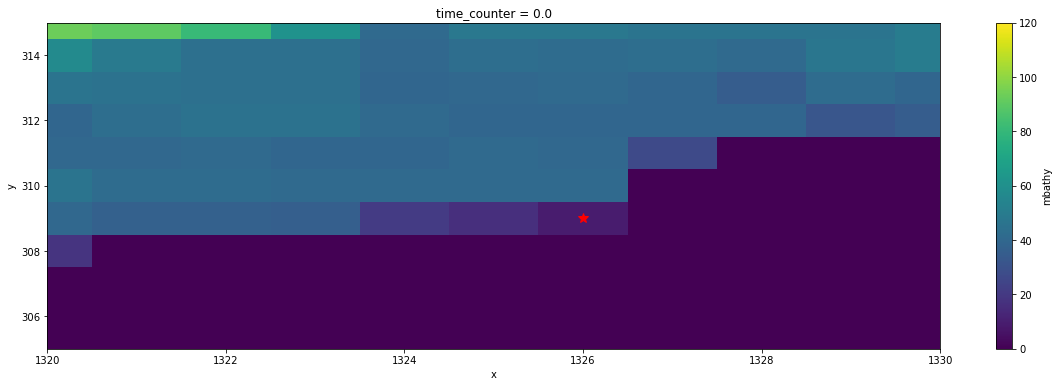

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
meshmask_new.mbathy.isel(time_counter=0).plot(ax=ax, xlim=(1320, 1330), ylim=(305, 315))
ax.plot([1326],[309], '*r', markersize=10);

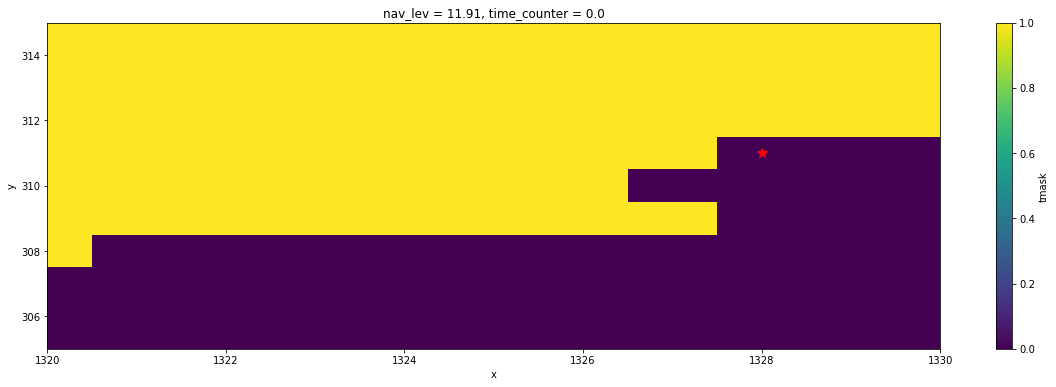

In [10]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
meshmask.tmask.ise(time_counter=0,nav_lev=8).plot(ax=ax, xlim=(1320, 1330), ylim=(305, 315))
ax.plot([1328],[311], '*r', markersize=10);

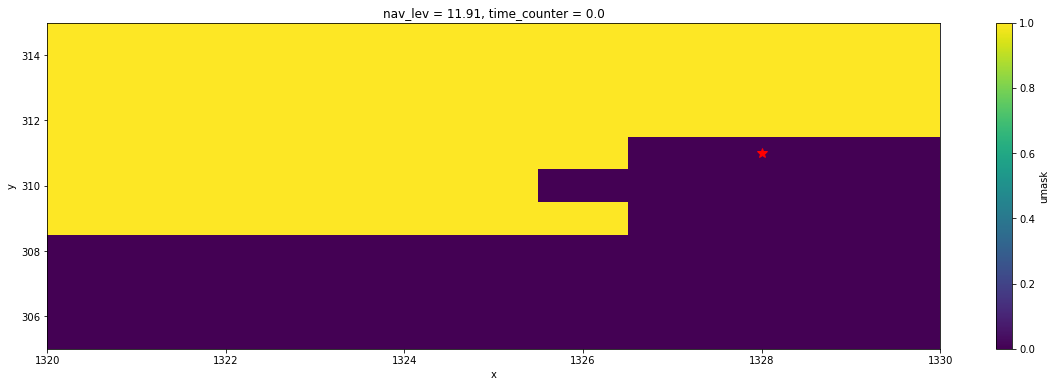

In [7]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
meshmask.umask.isel(time_counter=0,nav_lev=8).plot(ax=ax, xlim=(1320, 1330), ylim=(305, 315))
ax.plot([1328],[311], '*r', markersize=10);

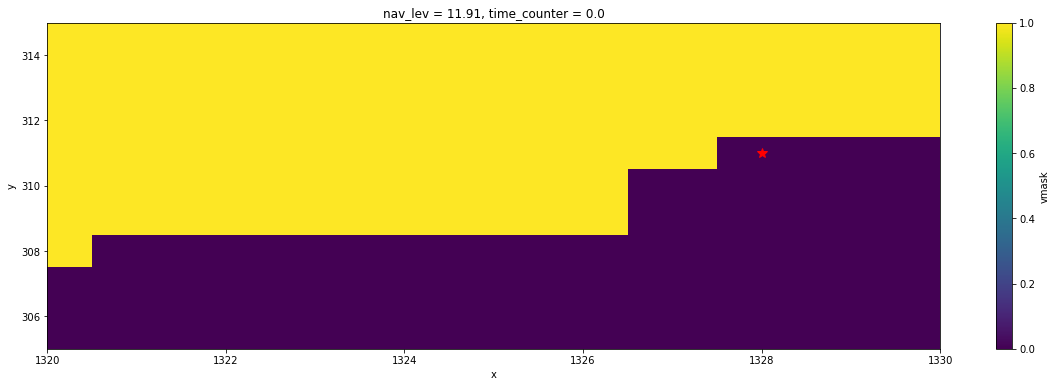

In [8]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
meshmask.vmask.isel(time_counter=0,nav_lev=8).plot(ax=ax, xlim=(1320, 1330), ylim=(305, 315))
ax.plot([1328],[311], '*r', markersize=10);